In [ ]:
import warnings

from datetime import timedelta
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Lasso

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import median_absolute_error

from lightautoml.tasks import Task
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

from IPython.display import display


warnings.filterwarnings('ignore')

cm = sns.light_palette("#1D58DA", as_cmap=True)
sns.set_style("ticks")
sns.set_palette(["#1D58DA", "#0E275C"])

In [6]:
TARGET = 'Hardness'
RANDOM_STATE = 42


def timeout(delta: int | timedelta) -> int:
    """returns total timeout in seconds 

    :param int | timedelta delta: seconds or timedelta
    :return int: seconds
    """

    if isinstance(delta, int):
        return delta

    return int(delta.total_seconds())

def display_df(df: pd.DataFrame):
    """defines style for displaying dataframe

    :param pd.DataFrame df: dataframe to display
    """
    display(df.style.background_gradient(cmap=cm))

# 🪨 Regression with a Mohs Hardness Dataset

## 💿 Загрузка датасета

In [9]:
def load(drop_id: bool = True) -> tuple[pd.DataFrame, pd.DataFrame]:
    """loads dataset

    :param bool drop_id: if true drops id in dataset, defaults to True
    :return tuple[pd.DataFrame, pd.DataFrame]: dataset with target and test for submissions
    """
    dirpath = Path('playground-series-s3e25')

    dataset = pd.read_csv(dirpath / 'train.csv')
    test = pd.read_csv(dirpath / 'test.csv')

    if drop_id:
        dataset.drop(['id'], axis=1, inplace=True)

    return dataset, test

dataset, test = load()

display(dataset)
display(test)

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8
10405,38.0,1.553160,12.666667,4.666667,26.621687,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,6.0


,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.360000,5.280000,82.561240,9.370384,2.298000,1.907200,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.000000,5.600000,39.568056,12.086300,2.868000,1.652000,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.600000,4.800000,23.231818,11.023840,2.644000,1.794000,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.000000,4.800000,20.298893,12.086300,2.828000,1.662000,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.000000,4.000000,22.977675,11.280950,2.455000,1.750000,0.893333,0.476095,0.93456
...,...,...,...,...,...,...,...,...,...,...,...,...
6934,17341,446.0,36.135392,9.636364,4.636364,19.689448,11.045515,2.768636,1.769697,0.871818,0.498702,0.11548
6935,17342,36.0,3.550000,18.000000,4.000000,36.068500,8.236600,1.790000,2.055000,1.390000,0.499000,1.35045
6936,17343,68.0,4.545328,11.333333,5.333333,22.688853,10.938358,2.876667,1.713333,0.916667,0.499074,0.73425
6937,17344,40.0,2.334164,6.666667,4.000000,13.016128,12.700467,2.770000,1.476667,0.616667,0.663797,0.51227


## 📈 Анализ целевой переменной

Hardness statistics,count,mean,std,min,25%,50%,75%,max,invalid count
Hardness,10407.000000,4.647126,1.680525,1.000000,3.000000,5.500000,6.000000,10.000000,0


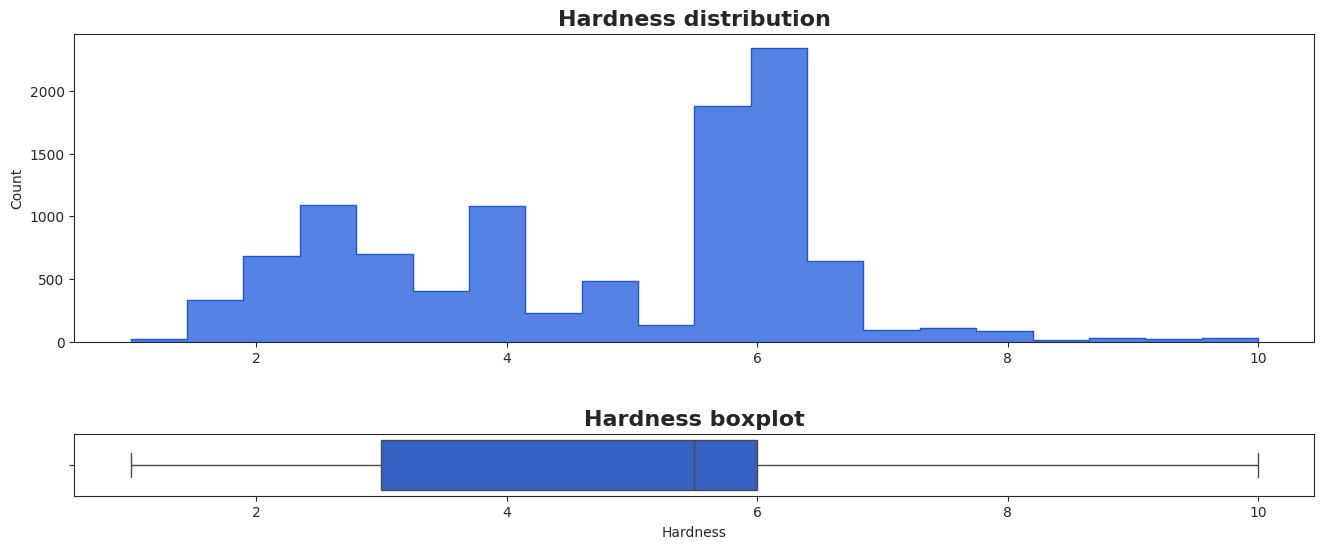

In [61]:
def describe_target():
    """plots target describe (statistics, invalid counts, histogram and boxplot)"""

    y = dataset[TARGET]

    stats = pd.DataFrame(y).describe().T
    stats['invalid count'] = y.isna().sum()
    stats.columns.name = f'{TARGET} statistics'

    display_df(stats)

    fig, (ax1, ax2) = plt.subplots(
        nrows=2, ncols=1,
        figsize=(16, 6),
        gridspec_kw={'height_ratios': [5, 1], 'hspace': 0.5})

    ax1.set_title(f'{TARGET} distribution', fontsize=16, fontweight='bold')
    sns.histplot(y.to_numpy(), bins=20, element='step', fill=True, ax=ax1)

    ax2.set_title(f'{TARGET} boxplot', fontsize=16, fontweight='bold')
    sns.boxplot(x=y, ax=ax2)

    fig.subplots_adjust(hspace=0.5)


describe_target()

**Вывод**

- получил распределение `Hardness`
- провел поиск аномальных значений

Распределение целевой переменной `Hardness` выглядит одновершинным, с основной массой значений примерно в диапазоне от 3 до 7, что соответствует ожидаемому диапазону для шкалы Мооса. При этом есть небольшое количество наблюдений с более высокими значениями (до ~10), образующих правый хвост распределения, то есть таргет имеет умеренную правостороннюю асимметрию.

На усах и немного выше видны потенциальные выбросы с высокими значениями `Hardness`, однако их число невелико, поэтому на первом этапе их разумно оставить в данных и только зафиксировать как возможные аномальные наблюдения для дальнейшего анализа.

## 🔎Анализ признаков

### Типизация признаков

In [39]:
numerical_features = dataset.drop([TARGET], axis=1).select_dtypes(include=[np.number]).columns.tolist()
categorical_features = dataset.drop([TARGET], axis=1).select_dtypes(include=["object"]).columns.tolist()


print(f"""
- Общее колличество призднаков: {len(numerical_features) + len(categorical_features)}
- Числовые призднаки: ({len(numerical_features)}): {"".join(f"\n * {f}" for f in numerical_features)}
- Категориальные признаки ({len(categorical_features)}): {"".join(f"\n * {f}" for f in categorical_features)}
"""
)



- Общее колличество призднаков: 11
- Числовые призднаки: (11): 
 * allelectrons_Total
 * density_Total
 * allelectrons_Average
 * val_e_Average
 * atomicweight_Average
 * ionenergy_Average
 * el_neg_chi_Average
 * R_vdw_element_Average
 * R_cov_element_Average
 * zaratio_Average
 * density_Average
- Категориальные признаки (0): 



**Описание призднаков**

 * `allelectrons_Total` - суммарное количество электронов во всех элементах состава минерала.​
 * `density_Total` - суммарная (или эффективная) плотность материала, рассчитанная по элементному составу.​
 * `allelectrons_Average` - среднее число электронов на атом в составе минерала.​
 * `val_e_Average` - среднее число валентных электронов на атом, характеризует способность к образованию химических связей.​
 * `atomicweight_Average` - средняя атомная масса элементов в составе.​
 * `ionenergy_Average` - средний потенциал ионизации элементов, отражает, насколько легко атомы отдают электроны.​
 * `el_neg_chi_Average` - средняя электроотрицательность (по Паулингу или схожей шкале), описывает склонность атомов притягивать электроны.​  
 * `R_vdw_element_Average` - средний атомный радиус Ван дер Ваальса.
 * `R_cov_element_Average`- средний ковалентный атомный радиус.
 * `zaratio_Average` - среднее атомное число, деленное на массовое число.
 * `density_Average` - средняя атомная плотность элемента.


Заметим, что признаки относятся к _микроскопическим_ свойствам, когда целевая переменная - _макроскопическая_ характеристика

In [43]:
display_df(dataset[numerical_features].describe().T)

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,10407.000000,128.053516,224.123776,0.000000,68.000000,100.000000,131.000000,15300.000000
density_Total,10407.000000,14.491342,15.972877,0.000000,7.558488,10.650000,16.676996,643.093804
allelectrons_Average,10407.000000,17.033222,10.468734,0.000000,10.000000,12.600000,22.000000,67.000000
val_e_Average,10407.000000,4.546789,0.690864,0.000000,4.000000,4.714286,4.800000,6.000000
atomicweight_Average,10407.000000,37.507703,26.012313,0.000000,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10407.000000,10.938308,1.408276,0.000000,10.590660,11.202760,11.670725,15.245810
el_neg_chi_Average,10407.000000,2.607662,0.334906,0.000000,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10407.000000,1.731330,0.192481,0.000000,1.672500,1.732727,1.800000,2.250000
R_cov_element_Average,10407.000000,0.944132,0.180017,0.000000,0.864000,0.915556,0.981667,1.615840
zaratio_Average,10407.000000,0.493349,0.063080,0.000000,0.476196,0.488550,0.496070,0.825990


### Выявление аномальных значений признаков и из распределения  

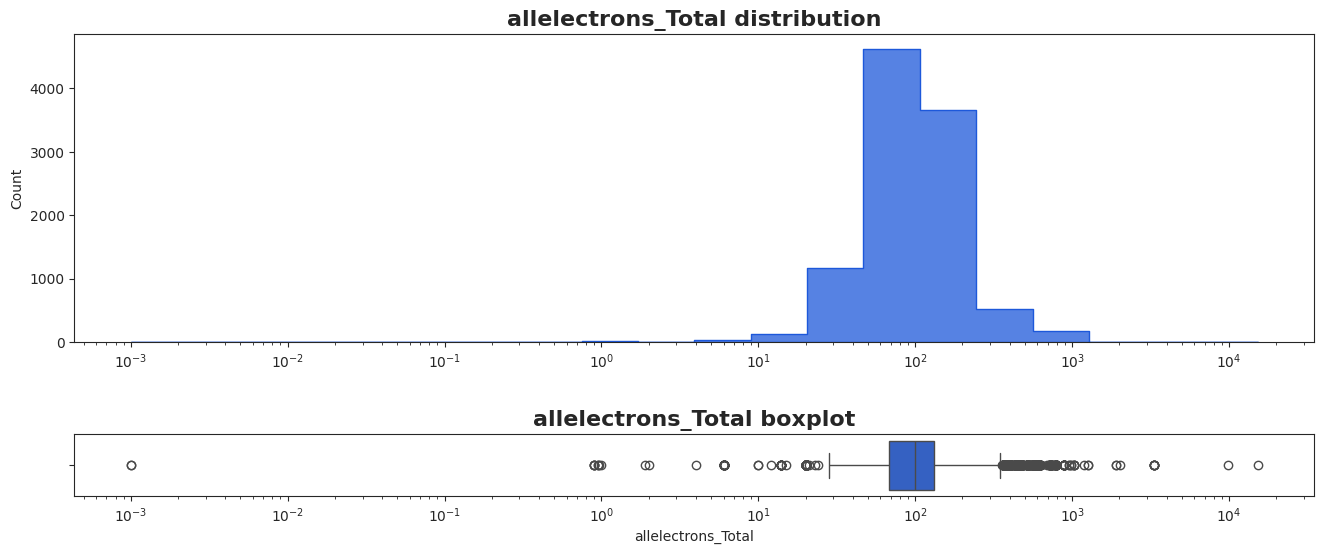

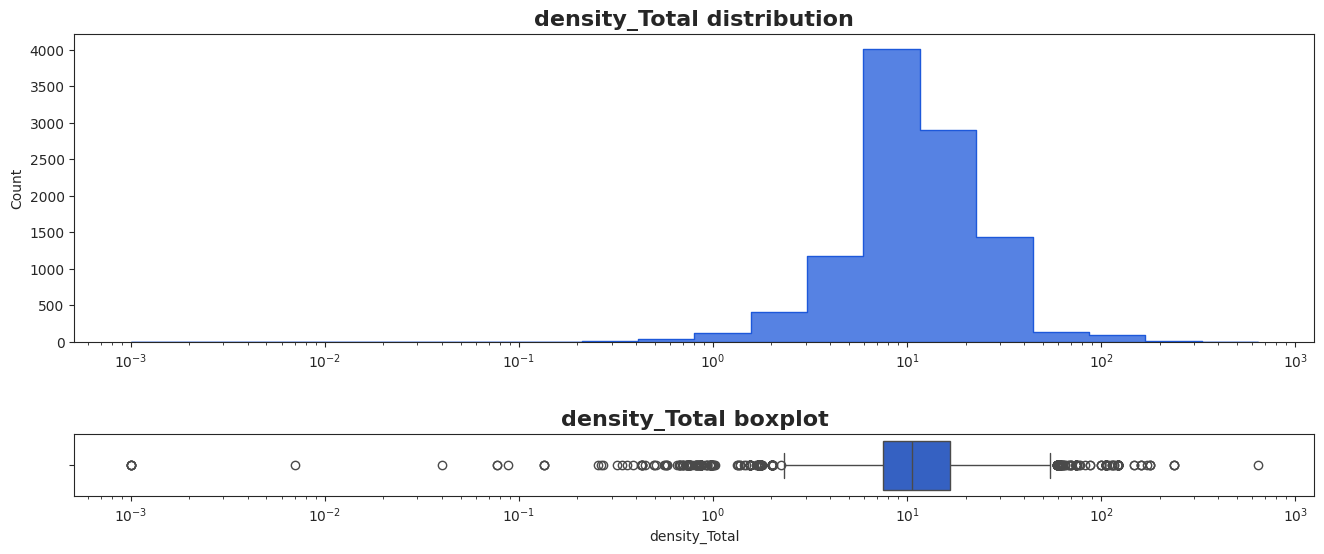

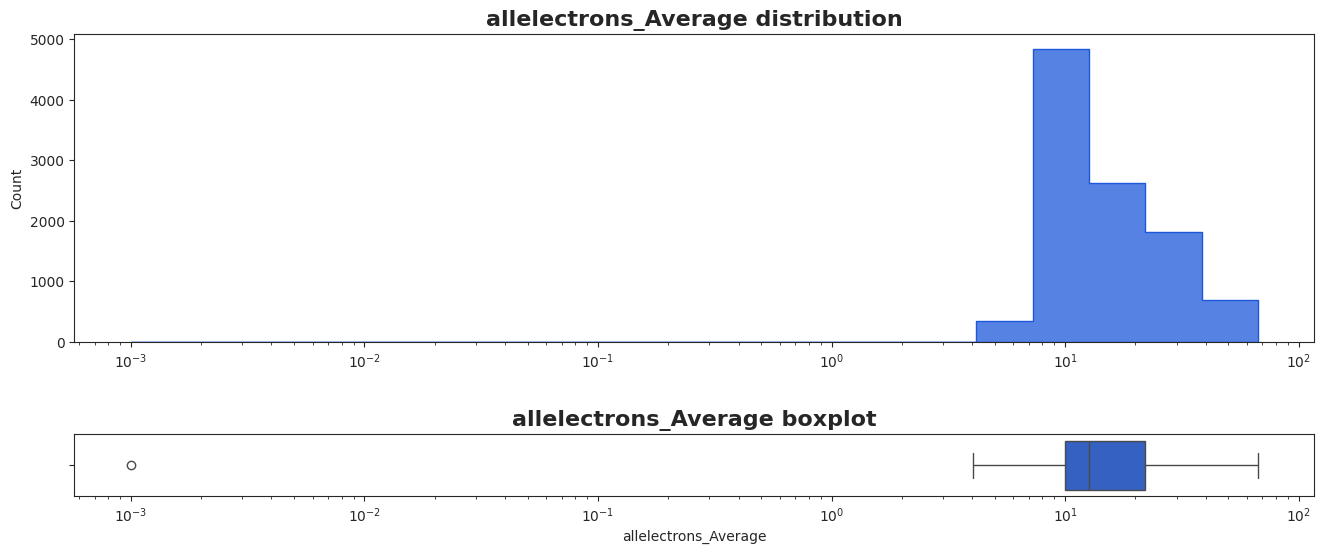

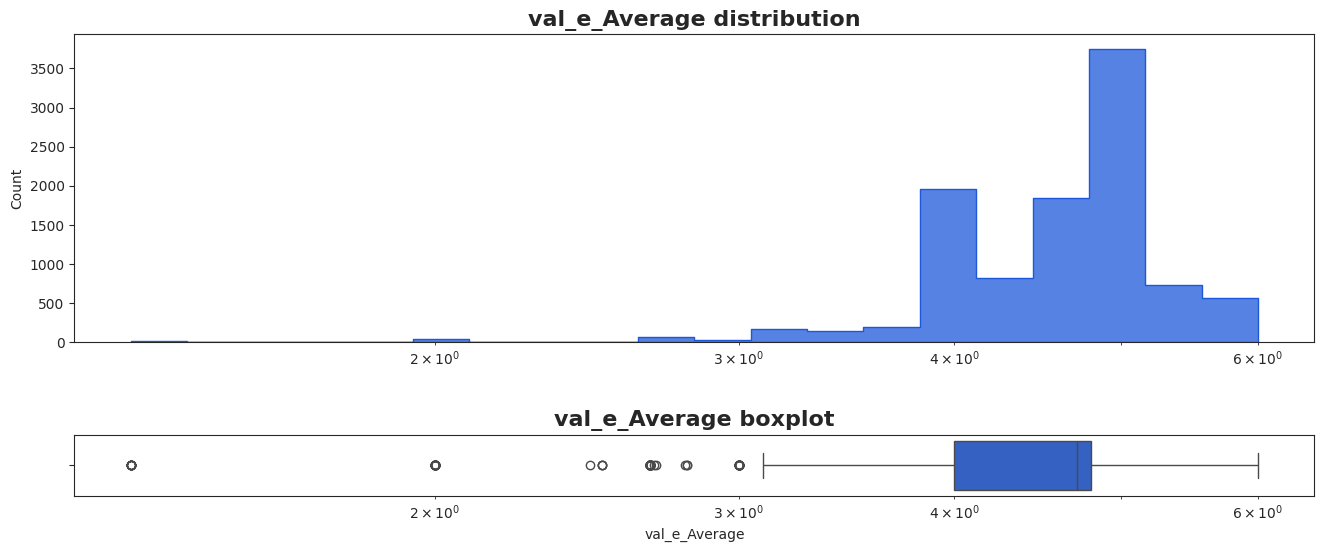

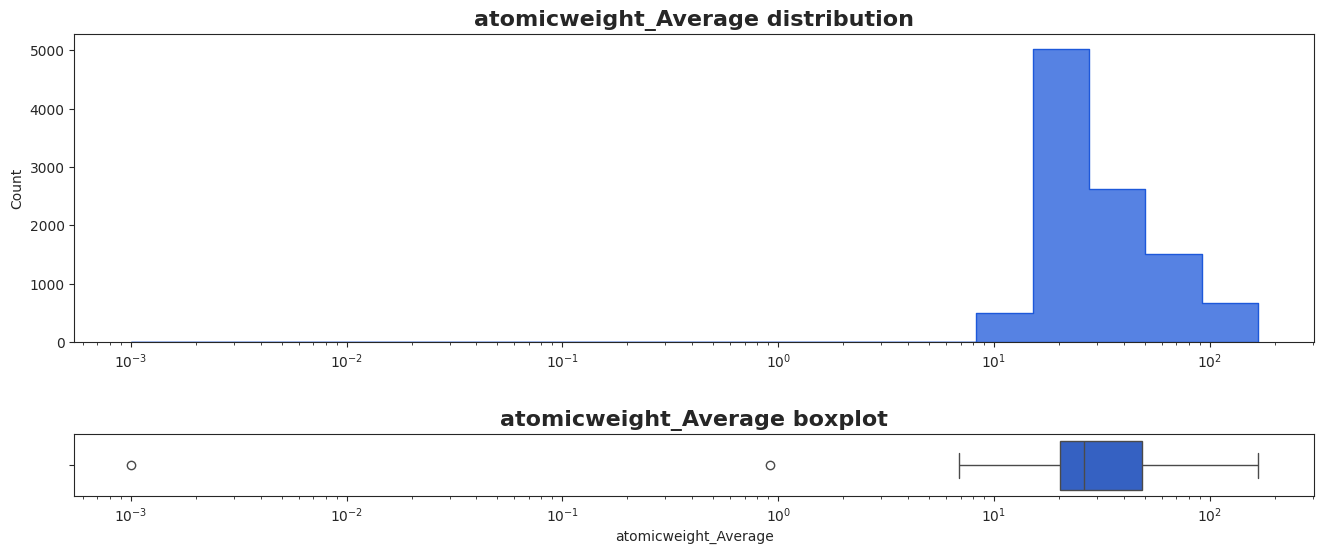

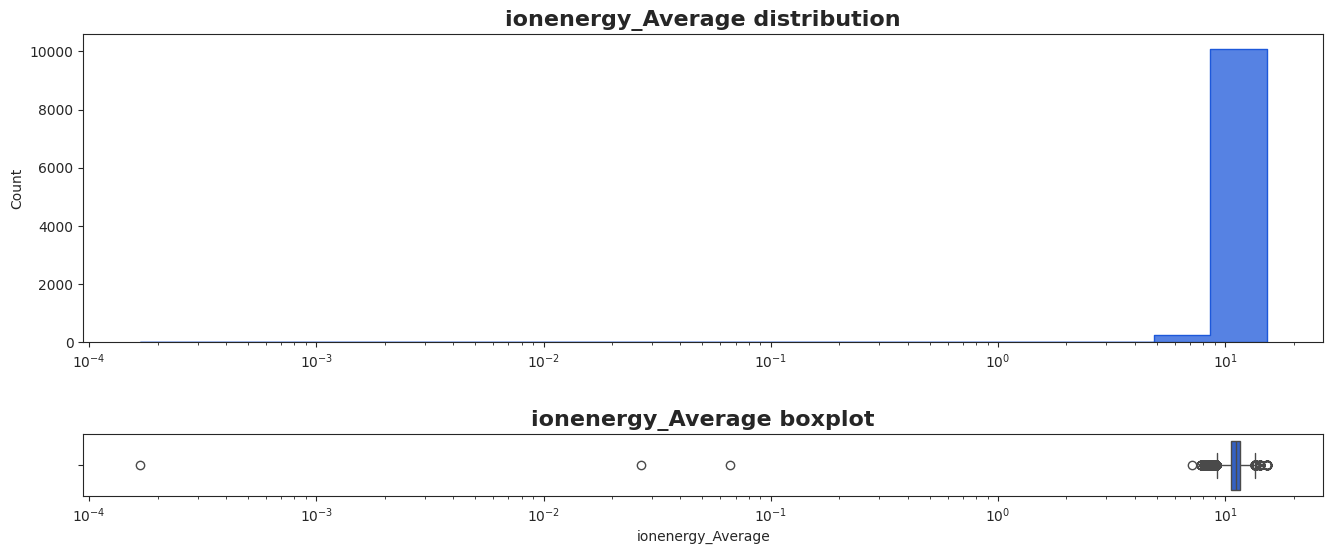

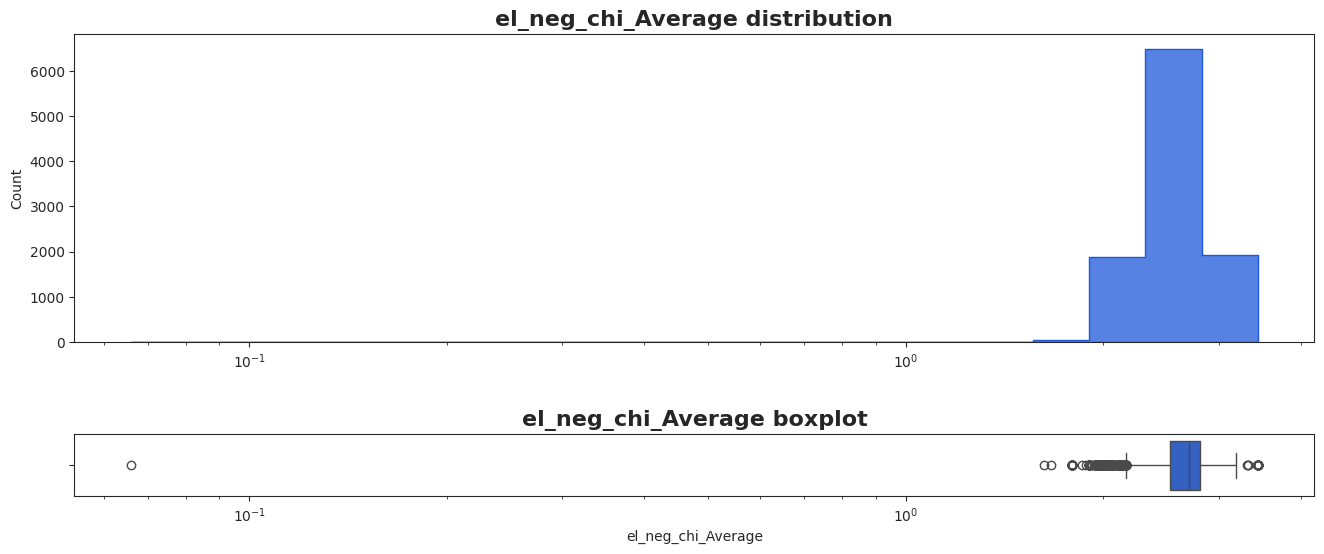

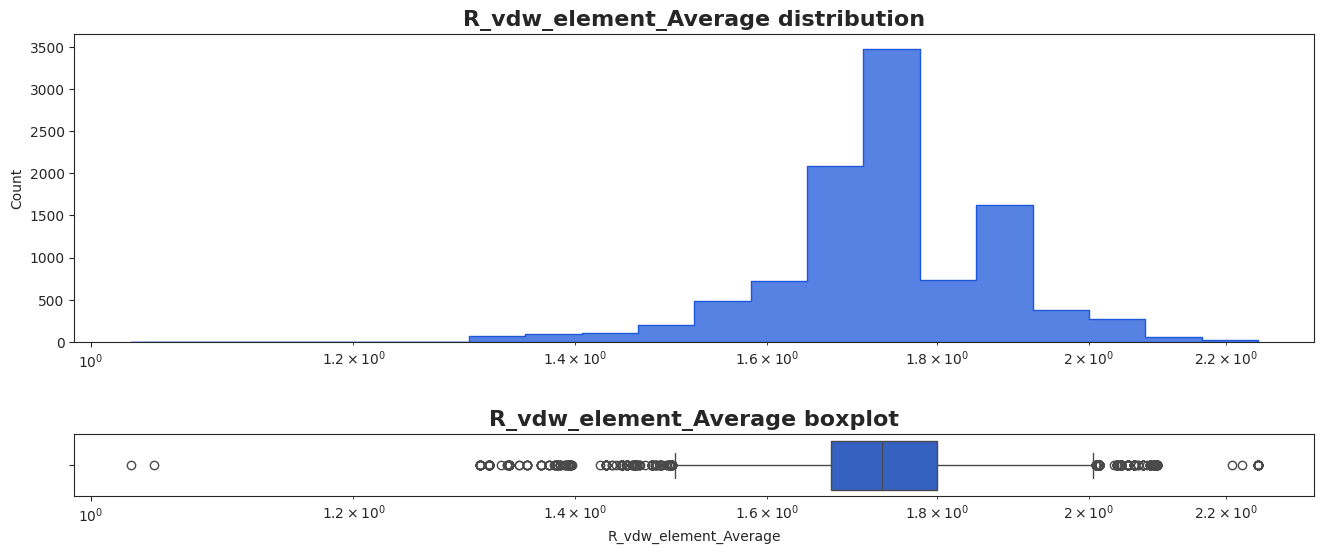

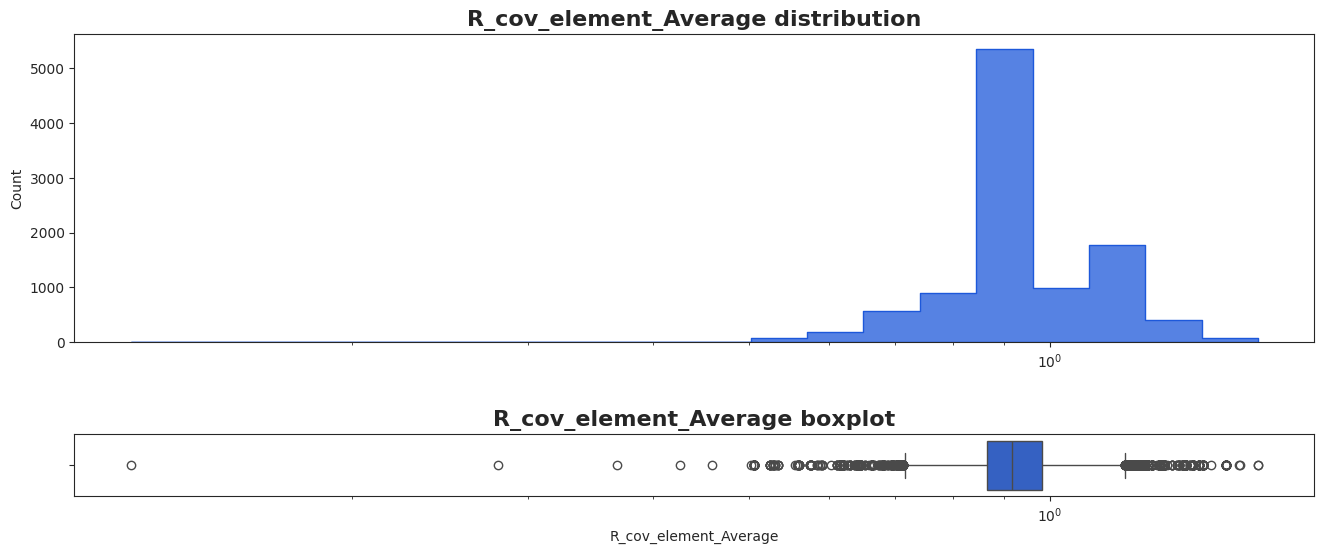

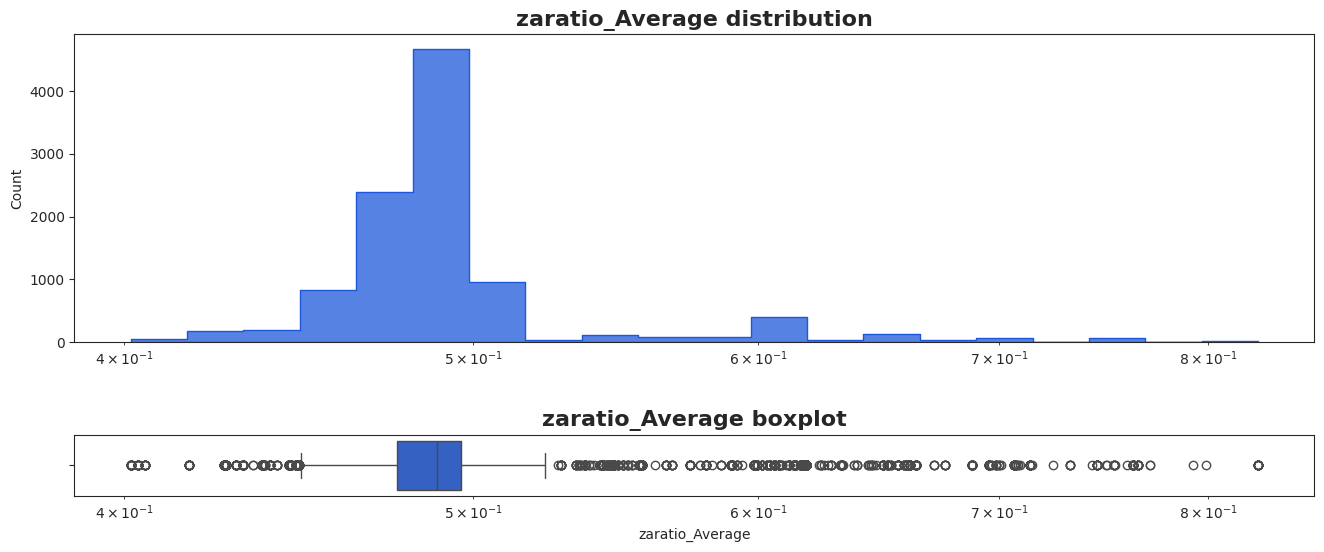

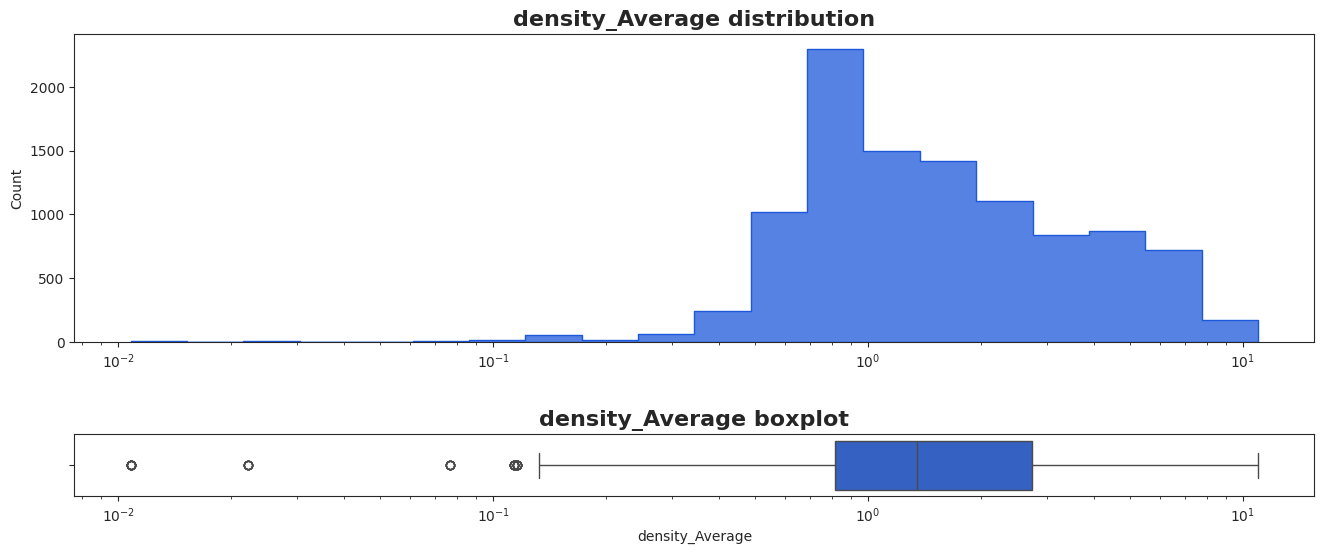

In [60]:
def plot_feature_distribution(feature: str):
    """displays histogram and boxplot for feature

    :param str feature: _description_
    """
    fig, (ax1, ax2) = plt.subplots(
        nrows=2, ncols=1,
        figsize=(16, 6),
        gridspec_kw={'height_ratios': [5, 1], 'hspace': 0.5})

    ax1.set_title(f'{feature} distribution', fontsize=16, fontweight='bold')
    sns.histplot(
        dataset[feature].to_numpy(),
        bins=20,
        ax=ax1,
        element='step',
        fill=True,
        log_scale=(True, False)
    )

    ax2.set_title(f'{feature} boxplot', fontsize=16, fontweight='bold')
    sns.boxplot(x=dataset[feature], ax=ax2, log_scale=True)

    display()


for feature in numerical_features:
    plot_feature_distribution(feature)

In [62]:
def features_outliers():
    """displays number of outliers for each feature"""

    outlier_mask = pd.DataFrame(
        False, index=dataset.index, columns=numerical_features
    )

    for feature in numerical_features:
        q1 = dataset[feature].quantile(0.25)
        q3 = dataset[feature].quantile(0.75)

        iqr = q3 - q1
        lower = q1 - (iqr * 1.5)
        upper = q3 + (iqr * 1.5)

        outlier_mask[feature] = (dataset[feature] < lower) | (
            dataset[feature] > upper)

    display_df(pd.DataFrame(outlier_mask.sum().sort_values(ascending=False)))


features_outliers()

,0
R_cov_element_Average,1869
zaratio_Average,1531
allelectrons_Total,1013
density_Total,865
density_Average,785
el_neg_chi_Average,758
R_vdw_element_Average,729
atomicweight_Average,666
ionenergy_Average,619
allelectrons_Average,597


### Анализ зависимостей между признаками

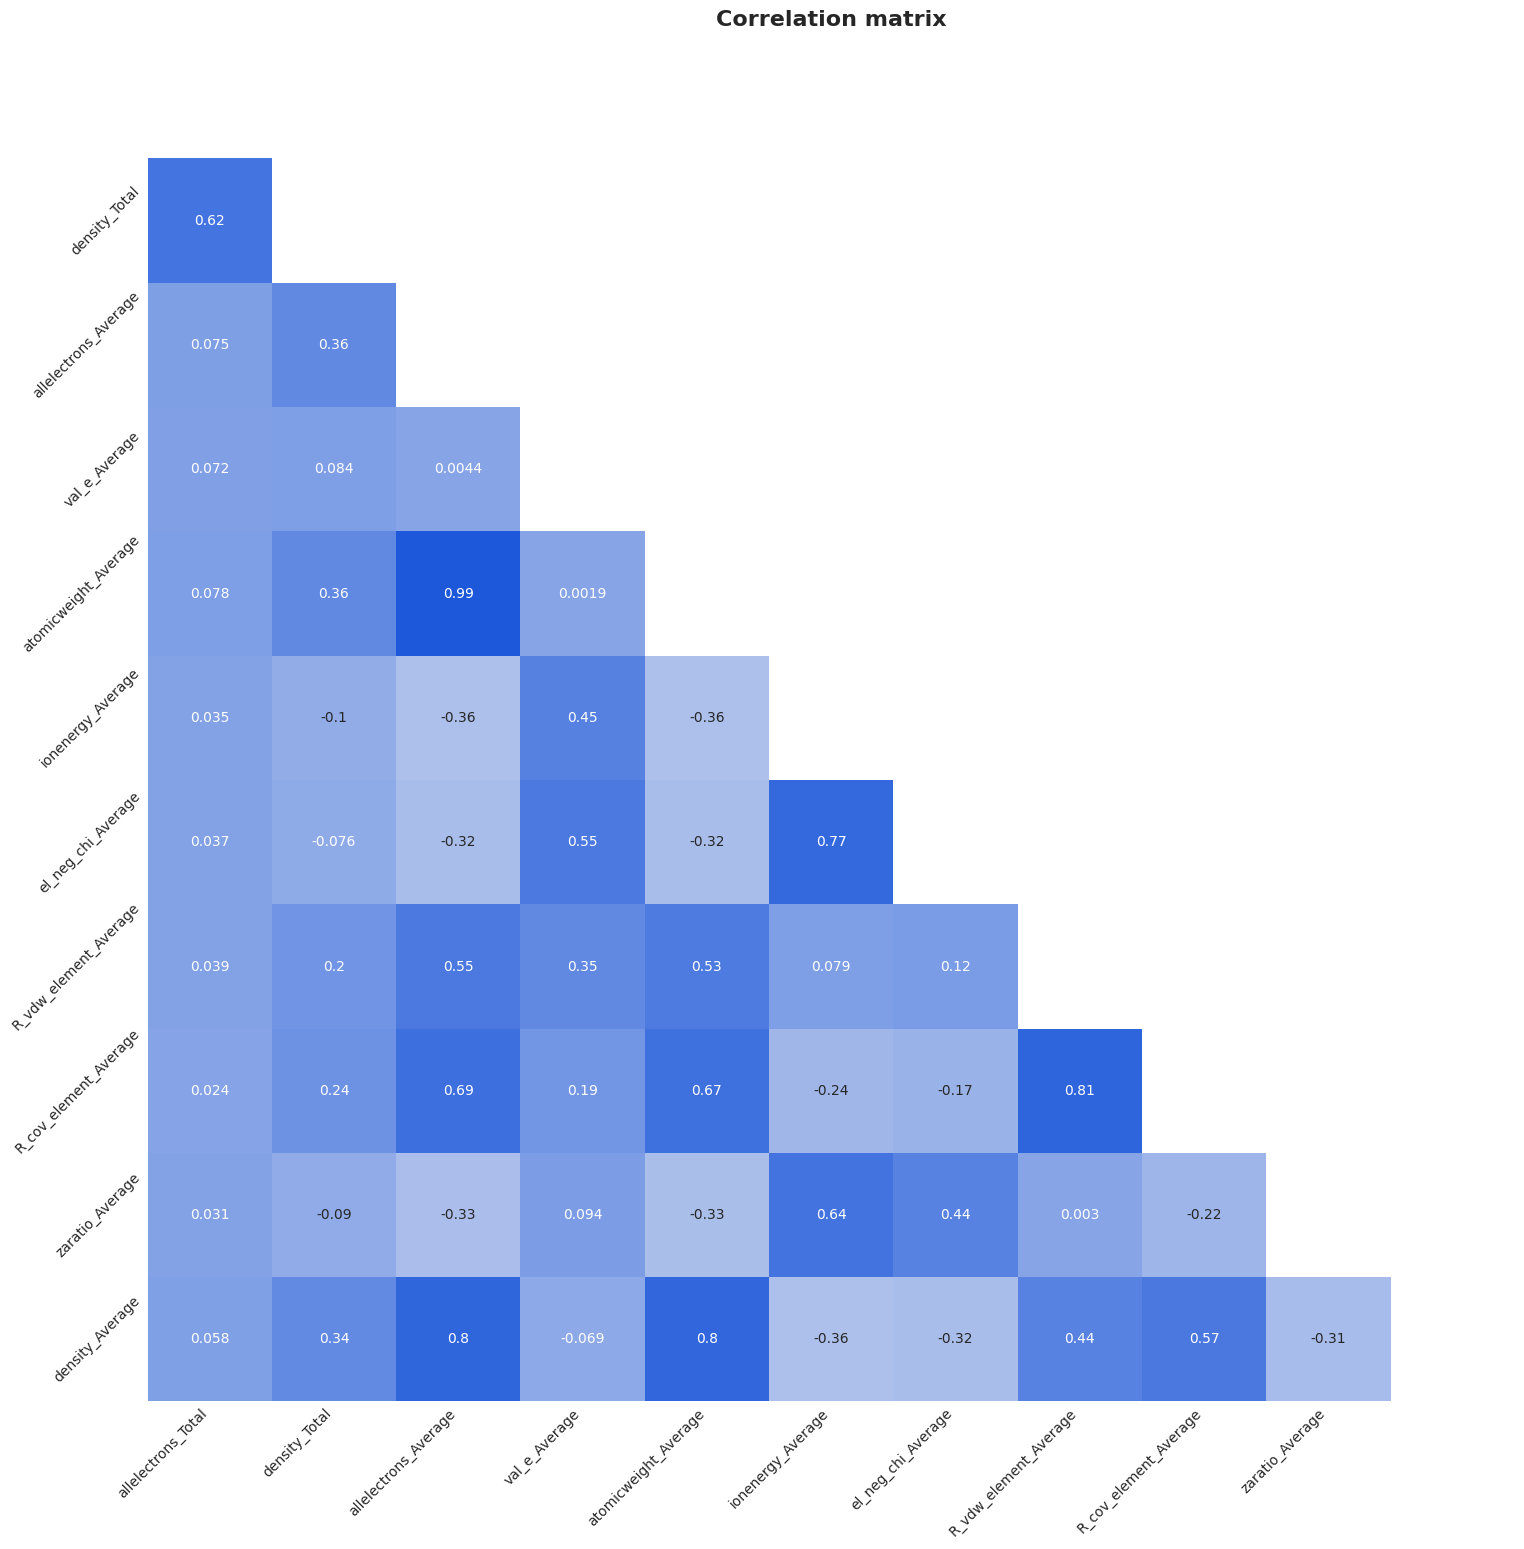

In [71]:
def features_correlation():
    """plots correlation matrix"""

    corr = dataset[numerical_features].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(16, 16))
    sns.heatmap(
        corr,
        ax=ax,
        mask=mask,
        cmap=cm,
        annot=True,
        center=0,
        square=True,
        cbar=False
    )

    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='y', length=0)

    xticklabels = ax.get_xticklabels()
    xticklabels[-1].set_visible(False)

    yticklabels = ax.get_yticklabels()
    yticklabels[0].set_visible(False)

    ax.set_title('Correlation matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax.get_yticklabels(), rotation=45, va='center')
    display()


features_correlation()

### Анализ пропущенных значений

In [73]:
def describe_nan():
    """displays missing values count and percent"""

    missing_percent = (dataset.isna().sum() / len(dataset)) * 100
    display_df(pd.DataFrame(missing_percent))

describe_nan()

,0
allelectrons_Total,0.000000
density_Total,0.000000
allelectrons_Average,0.000000
val_e_Average,0.000000
atomicweight_Average,0.000000
ionenergy_Average,0.000000
el_neg_chi_Average,0.000000
R_vdw_element_Average,0.000000
R_cov_element_Average,0.000000
zaratio_Average,0.000000


### Определение важности признаков (корреляции с таргетом)

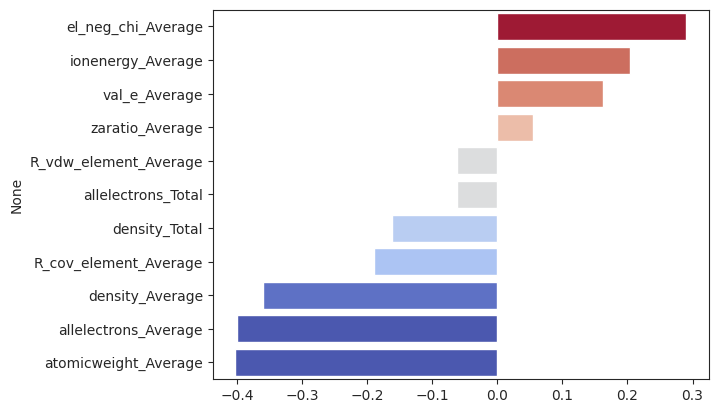

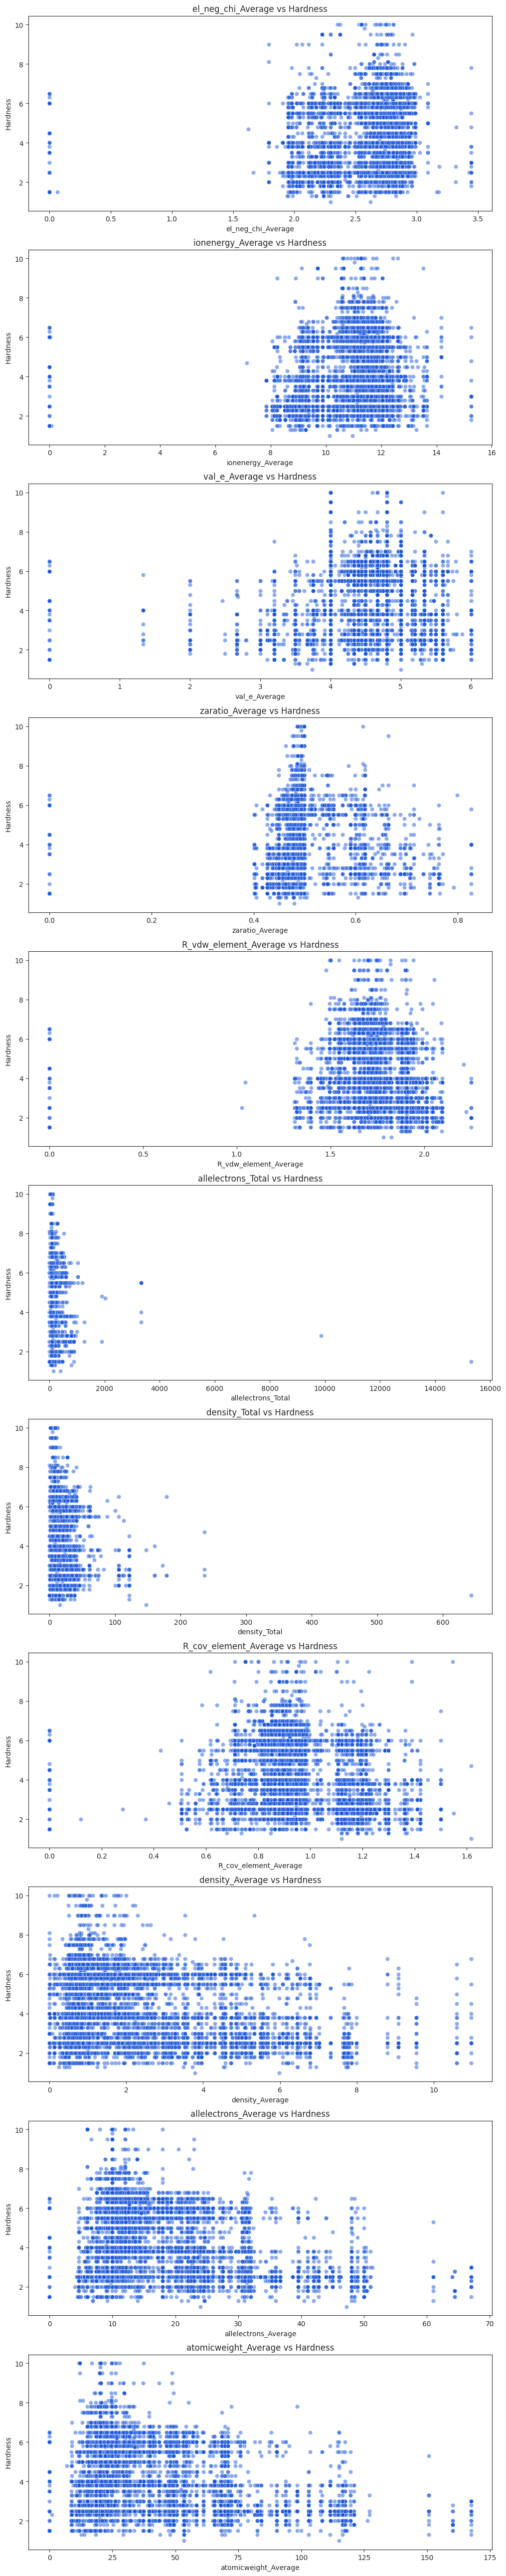

In [77]:
def target_correlation():
    """plots correlation between target and features"""

    corr = dataset[numerical_features + [TARGET]].corr()

    target_corr = corr[TARGET].drop(TARGET).sort_values(ascending=False)
    
    sns.barplot(
        x=target_corr.values,
        y=target_corr.index, 
        palette='coolwarm',
        hue=target_corr.values,
        legend=False
    )

    display()

    fig, axes = plt.subplots(len(target_corr), 1, figsize=(12, 6*len(target_corr)))
    axes = axes.flatten()

    for idx, feature in enumerate(target_corr.index):
        sns.scatterplot(data=dataset, x=feature, y=TARGET, ax=axes[idx], alpha=0.5)
        axes[idx].set_title(f'{feature} vs {TARGET}')
    
    display()

target_correlation()

### Анализ возможных преобразований и генерации новых признаков

,Hardness
el_neg_chi_Average_squared,0.306989
el_neg_chi_Average_x_ionenergy_Average,0.272230
ionenergy_Average_squared,0.185485
allelectrons_Total_log,-0.030385
density_Total_log,-0.124178
atomicweight_Average_log,-0.275924
allelectrons_Average_log,-0.289252
density_Average_log,-0.321957
el_neg_chi_Average_x_allelectrons_Average,-0.371501
el_neg_chi_Average_x_atomicweight_Average,-0.378178


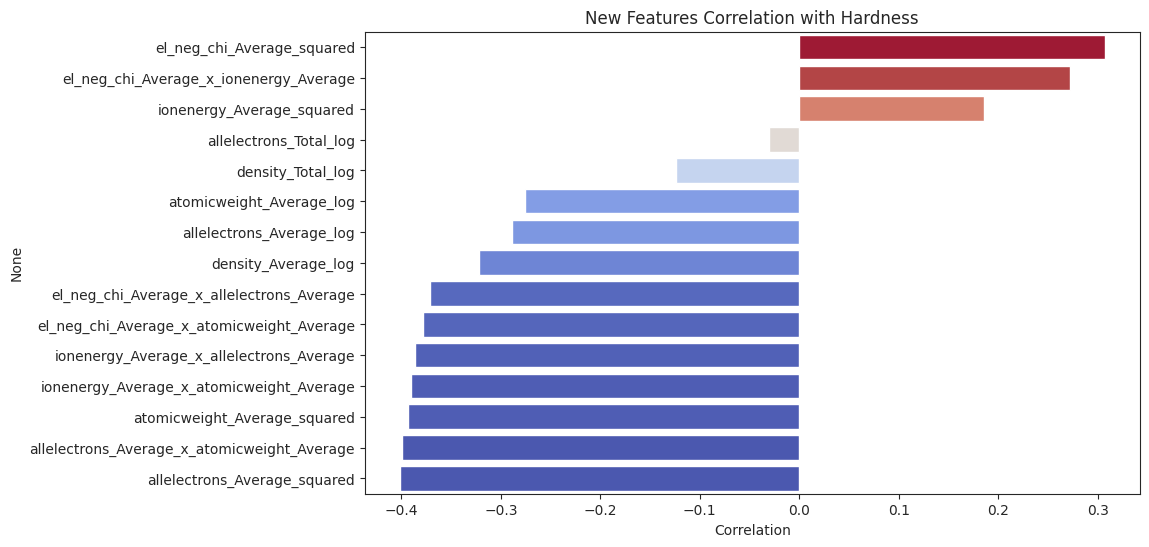

In [83]:
def make_new_features():
    """makes new features from existing and plots correlation"""
    
    dataset_transformed = dataset.copy()

    # @note: эти фичи имеют большой правый хвост в распределении, так что возмодно имеет смысл их логорифмировать
    log_features = [
        'allelectrons_Total',
        'allelectrons_Average',
        'atomicweight_Average',
        'density_Total',
        'density_Average'
    ] 

    for col in log_features:
        dataset_transformed[f'{col}_log'] = np.log1p(dataset_transformed[col])

    # @note: эти фичи имеют высокую корреляцию с таргетом, так что для них имеет смысл усилить нелинейные связи
    #        также проверяем гипотезу Hardness \sim a⋅x2+b⋅x+c
    top_abs_corr_features = [
        'el_neg_chi_Average',
        'ionenergy_Average',
        'allelectrons_Average',
        'atomicweight_Average'
    ]

    for col in top_abs_corr_features:
        dataset_transformed[f'{col}_squared'] = dataset_transformed[col] ** 2

    for i in range(len(top_abs_corr_features)):
        for j in range(i+1, len(top_abs_corr_features)):
            left, right = top_abs_corr_features[i], top_abs_corr_features[j]
            dataset_transformed[f'{left}_x_{right}'] = dataset_transformed[left] * dataset_transformed[right]

    new_features = dataset_transformed.columns.difference(dataset.columns)
    
    new_corr = dataset_transformed[list(
        new_features) + [TARGET]].corr()[TARGET].drop(TARGET).sort_values(ascending=False)
    display_df(pd.DataFrame(new_corr))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=new_corr.values, y=new_corr.index,
                palette='coolwarm', hue=new_corr.values, legend=False)
    plt.title('New Features Correlation with Hardness')
    plt.xlabel('Correlation')

    display()



make_new_features()


**Выводы по анализу призднаков**

1. Все 11 числовых признаков описывают агрегированные физико-химические свойства минералов.
2. Анализ боксплотов показал высокое количество потенциальных выбросов.

    Признаки в высоким колличеством выбросов:
     - `R_cov_element_Average` (1869)
     - `zaratio_Average` (1531)
     - `allelectrons_Total` (1613)
     - `density_Total` (865) 

    Высокое количество выбросов указывает на использование robust методов для этих фичей.

3. Анализ зависимостей между признаками и таргетом

    Положительно коррелирующие с твердостью:
    - `el_neg_chi_Average` (электроотрицательность) – сильнейший предиктор
    - `ionenergy_Average` (энергия ионизации)
    - `val_e_Average` (валентные электроны)

    Отрицательно коррелирующие:
    - `atomicweight_Average` (атомная масса) – самая сильная отрицательная корреляция
    - `allelectrons_Average` (среднее число электронов)
    - `density_Average` (средняя плотность)

    Твердость растёт с электроотрицательностью элементов (элементы с более прочными связями), но падает с атомной массой и количеством электронов. Это соответствует физике: тяжёлые металлические элементы обычно мягче неметаллов.

4. Датасет полностью заполнен – нет пропусков ни в обучающей, ни в тестовой выборке.

5. Анализ преобразований и новых призднаков.
    Лучшие новые призднаки:
     - `el_neg_chi_Average_squared`
     - `el_neg_chi_x_ionenergy_Average`
    
    Квадраты исходных признаков выигрывают, потому что электроотрицательность имеет нелинейный эффект на твердость.
    Логорифмы в свою очередь не показали сильного улучшения в корреляциях.

## 🧠 Моделирование

### Разделение данных 

Будем использовать `KFold` кросс валидацию, так как:
- нет временных зависимостей
- задача регрессии

In [115]:
kfd = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [116]:
submissions = Path('submissions')
if not submissions.exists():
    submissions.mkdir()

def automl_submit(model: TabularAutoML | TabularUtilizedAutoML, name: str):
    """make submission to kaggle 

    :param TabularAutoML model: trained model
    :param str name: filename to save by
    """

    pred = model.predict(test)
    df = pd.DataFrame({'id': test['id'], TARGET: pred.data.reshape(-1)})
    display(df)

    df.to_csv(submissions / f'{name}.csv', index=False)


def display_automl_score(oof_pred):
    """computes and displays MadAE score

    :param oof_pred: out of fold predictions for dataset 
    """
    
    score = median_absolute_error(dataset[TARGET].to_numpy(), oof_pred.data.reshape(-1))
    print(f'MadAE: {score:.5f}')


### Lightautoml `TabularAutoML`

В качестве метрики использую `mae`. Это связано score метрикой соревнования: `medae` - метиана абсолютных ошибок. Соотвественно там важнее оптимизировать именно абсолютные ошибки. 

In [85]:
task = Task(name='reg', metric='mae')

MEMORY_LIMIT = 14
CPU_LIMIT = 4

In [86]:
automl1 = TabularAutoML(
    task=task,
    timeout=timeout(timedelta(minutes=20)),
    cpu_limit=CPU_LIMIT,
    memory_limit=MEMORY_LIMIT,
    reader_params={
        'n_jobs': CPU_LIMIT,
        'cv': 5,
        'random_state': RANDOM_STATE,
    }
)

oof_preds1 = automl1.fit_predict(
    dataset,
    roles={'target': TARGET},
    verbose=1
)

[18:47:30] Stdout logging level is INFO.
[18:47:30] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[18:47:30] Task: reg

[18:47:30] Start automl preset with listed constraints:
[18:47:30] - time: 1200.00 seconds
[18:47:30] - CPU: 4 cores
[18:47:30] - memory: 14 GB

[18:47:30] Train data shape: (10407, 12)

[18:47:33] Layer 1 train process start. Time left 1196.96 secs
[18:47:33] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[18:47:34] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.9483396805926085
[18:47:34] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[18:47:34] Time left 1195.74 secs

[18:47:35] Selector_LightGBM fitting and predicting completed
[18:47:35] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[18:47:39] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.8770836901767827
[18:47:39] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[18:47:39] Start hyperparameters optimization for Lv

Optimization Progress: 100%|██████████| 101/101 [04:03<00:00,  2.41s/it, best_trial=64, best_value=-0.861]

[18:51:43] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[18:51:43] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[18:51:46] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.8847884394738336
[18:51:46] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[18:51:46] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[18:52:17] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.8918013529636862
[18:52:17] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[18:52:17] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:  49%|████▊     | 49/101 [05:03<05:22,  6.20s/it, best_trial=41, best_value=-0.867]

[18:57:21] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[18:57:21] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[18:57:49] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.8881895301013718
[18:57:49] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[18:57:49] Time left 581.42 secs

[18:57:49] Layer 1 training completed.

[18:57:49] Blending: optimization starts with equal weights. Score = -0.8844341
[18:57:49] Blending: iteration 0: score = -0.8747429, weights = [0.         0.64877474 0.3512253  0.         0.        ]
[18:57:49] Blending: iteration 1: score = -0.8747159, weights = [0.         0.6738541  0.32614592 0.         0.        ]
[18:57:49] Blending: no improvements for score. Terminated.

[18:57:49] Blending: best score = -0.8747159, best weights = [0.         0.6738541  0.32614592 0.         0.        ]
[18:57:49] Automl preset training completed in 618.66 seconds

[18:57:49] Model description:
Final prediction for new objects (level 0) = 
	 0.67385 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.32615 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned

In [154]:
print(automl1.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.67385 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.32615 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


In [91]:
display_automl_score(oof_preds1)
automl_submit(automl1, 'automl1')

MadAE: 0.63342


,id,Hardness
0,10407,2.515656
1,10408,2.752090
2,10409,5.819771
3,10410,4.365911
4,10411,5.226676
...,...,...
6934,17341,5.675168
6935,17342,4.100542
6936,17343,4.900085
6937,17344,4.378306


Получили для первого lama бейзлайна oof_medae = 0.63. 

### Lightautoml `TabularUtilizedAutoML`

In [92]:
automl2 = TabularUtilizedAutoML(
    task=task,
    timeout=timeout(timedelta(minutes=30)),
    cpu_limit=CPU_LIMIT,
    memory_limit=MEMORY_LIMIT,
    reader_params={
        'n_jobs': CPU_LIMIT,
        'cv': 5,
        'random_state': RANDOM_STATE,
    },
    general_params={
        'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned', 'xgb', 'xgb_tuned']]
    },
    tuning_params={
        'max_tuning_time': timeout(timedelta(minutes=10)),
        'early_stopping_rounds': 50
    },
)

oof_pred2 = automl2.fit_predict(dataset, roles={'target': TARGET}, verbose=1)

[19:04:49] Start automl utilizator with listed constraints:
[19:04:49] - time: 1800.00 seconds
[19:04:49] - CPU: 4 cores
[19:04:49] - memory: 14 GB

[19:04:49] If one preset completes earlier, next preset configuration will be started

[19:04:49] ==================================================
[19:04:49] Start 0 automl preset configuration:
[19:04:49] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[19:04:49] Stdout logging level is INFO.
[19:04:49] Task: reg

[19:04:49] Start automl preset with listed constraints:
[19:04:49] - time: 1800.00 seconds
[19:04:49] - CPU: 4 cores
[19:04:49] - memory: 14 GB

[19:04:49] Train data shape: (10407, 12)



[19:04:52] Layer 1 train process start. Time left 1797.18 secs
[19:04:53] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:04:53] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.9483396805926085
[19:04:53] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:04:53] Time left 1796.06 secs

[19:04:54] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:04:59] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.8750229598892357
[19:04:59] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:04:59] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 299.56 secs


Optimization Progress: 100%|██████████| 101/101 [03:52<00:00,  2.31s/it, best_trial=64, best_value=-0.859]

[19:08:52] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[19:08:52] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[19:08:55] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.8774276816962925
[19:08:55] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[19:08:55] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[19:08:59] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.8842725049721996
[19:08:59] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[19:08:59] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 600.00 secs


Optimization Progress: 100%|██████████| 101/101 [01:41<00:00,  1.01s/it, best_trial=86, best_value=-0.866]

[19:10:41] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[19:10:41] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[19:10:44] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.8841762714719549
[19:10:44] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[19:10:44] Start fitting Lvl_0_Pipe_1_Mod_4_XGBoost ...
[19:10:46] Fitting Lvl_0_Pipe_1_Mod_4_XGBoost finished. score = -0.9374519177906747
[19:10:46] Lvl_0_Pipe_1_Mod_4_XGBoost fitting and predicting completed
[19:10:46] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost ... Time budget is 600.00 secs


Optimization Progress: 100%|██████████| 101/101 [02:44<00:00,  1.63s/it, best_trial=64, best_value=-0.86]

[19:13:31] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost completed
[19:13:31] Start fitting Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost ...


[19:13:44] Fitting Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost finished. score = -0.8754001661614794
[19:13:44] Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost fitting and predicting completed
[19:13:44] Time left 1265.36 secs

[19:13:44] Layer 1 training completed.

[19:13:44] Blending: optimization starts with equal weights. Score = -0.8781034
[19:13:44] Blending: iteration 0: score = -0.8713839, weights = [0.         0.29972064 0.28614125 0.09145541 0.         0.
 0.32268274]
[19:13:44] Blending: iteration 1: score = -0.8713832, weights = [0.         0.3090323  0.27552363 0.09232127 0.         0.
 0.32312283]
[19:13:44] Blending: iteration 2: score = -0.8713830, weights = [0.         0.30301782 0.27792192 0.09312487 0.         0.
 0.3259354 ]
[19:13:44] Blending: no improvements for score. Terminated.

[19:13:44] Blending: best score = -0.8713830, best weights = [0.         0.30301782 0.27792192 0.09312487 0.         0.
 0.3259354 ]
[19:13:44] Automl preset training completed in 534.78 seconds

[19:13:44] Mo

Optimization Progress:  59%|█████▉    | 60/101 [03:14<02:13,  3.25s/it, best_trial=14, best_value=-0.871]

[19:17:10] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[19:17:10] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[19:17:14] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.8756356335666803
[19:17:14] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[19:17:14] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[19:17:19] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.8805840436248691
[19:17:19] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[19:17:19] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 486.75 secs


Optimization Progress: 100%|██████████| 101/101 [01:45<00:00,  1.05s/it, best_trial=0, best_value=-0.885]

[19:19:05] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[19:19:05] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[19:19:09] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.8857574755618332
[19:19:09] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[19:19:09] Start fitting Lvl_0_Pipe_1_Mod_4_XGBoost ...
[19:19:10] Fitting Lvl_0_Pipe_1_Mod_4_XGBoost finished. score = -0.9285528942949206
[19:19:10] Lvl_0_Pipe_1_Mod_4_XGBoost fitting and predicting completed
[19:19:10] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost ... Time budget is 600.00 secs


Optimization Progress: 100%|██████████| 101/101 [06:03<00:00,  3.60s/it, best_trial=72, best_value=-0.873]

[19:25:14] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost completed
[19:25:14] Start fitting Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost ...


[19:25:35] Fitting Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost finished. score = -0.8699680541738535
[19:25:35] Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost fitting and predicting completed
[19:25:35] Time left 554.59 secs

[19:25:35] Layer 1 training completed.

[19:25:35] Blending: optimization starts with equal weights. Score = -0.8756867
[19:25:35] Blending: iteration 0: score = -0.8670135, weights = [0.         0.27466452 0.21986859 0.09282712 0.         0.
 0.4126398 ]
[19:25:35] Blending: iteration 1: score = -0.8669975, weights = [0.         0.31238952 0.19971651 0.07926214 0.         0.
 0.4086318 ]
[19:25:35] Blending: no improvements for score. Terminated.

[19:25:35] Blending: best score = -0.8669975, best weights = [0.         0.31238952 0.19971651 0.07926214 0.         0.
 0.4086318 ]
[19:25:35] Automl preset training completed in 710.73 seconds

[19:25:35] Model description:
Final prediction for new objects (level 0) = 
	 0.31239 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.19972 * 

In [153]:
print(automl2.create_model_str_desc())

Final prediction for new objects = 
	0.40442 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.30302 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.27792 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.09312 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.32594 * (5 averaged models Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost) 


	+ 0.59558 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.31239 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.19972 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.07926 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.40863 * (5 averaged models Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost) 





In [ ]:
display_automl_score(oof_pred2)
automl_submit(automl2, 'automl2')

MadAE: 0.61264


,id,Hardness
0,10407,2.879310
1,10408,2.605658
2,10409,5.895464
3,10410,4.386181
4,10411,5.080504
...,...,...
6934,17341,5.517684
6935,17342,4.270369
6936,17343,5.041800
6937,17344,4.492372


Со вторым lama бейзлайном получилось улучшить oof_medae (0.63 -> 0.61)

### Собственное решение

**Архитектура решения**

1. Генерация новый призднаков:
    - Из анализа призднаков мы получили положительный результат от возведения в квадрат \ перемножения.
2. Препроцессинг:
    - Из анализа призднаков мы получили список призднаков, у которых много аномалий, будем использовать `RobustScaler`.
3. Выбор призднаков:
    - Так как мы генерируем новые фичи, сделаем фильтр фичей на основе предсказания `Lasso`
4. Предсказатели:
    - Будем использовать взвешанное предсказание `XGBRegressor` и `LGBMRegressor`. Такой подход позволит снизить валатильность предсказания.
    - Весы предсказателей - гипперпараметр, который можно в дальнейшем оптимизировать. 

In [95]:
robust_features = [
    'R_cov_element_Average',
    'zaratio_Average',
    'allelectrons_Total',
    'density_Total'
]

top_abs_corr_features = [
    'el_neg_chi_Average',
    'ionenergy_Average',
    'allelectrons_Average',
    'atomicweight_Average'
]

In [151]:
class AddSquaredFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols: list[str]):
        """transformer for adding squared features

        :param list[str] cols: list of dataframe columns
        """
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        for col in self.cols:
            X_new[f'{col}_squared'] = X_new[col] ** 2
        return X_new


class AddProductTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pairs: list[tuple[str, str]]):
        """transformer for adding product features

        :param list[tuple[str, str]] pairs: list of pairs of dataframe columns
        """
        self.pairs = pairs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        for col1, col2 in self.pairs:
            X_new[f'{col1}_{col2}_product'] = X_new[col1] * X_new[col2]
        return X_new

def make_pairs(cols: list[str]) -> list[tuple[str, str]]:
    """make pairs of columns

    :param list[str] cols: list of dataframe columns
    :return list[tuple[str, str]]: list of pairs
    """
    pairs = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            pairs.append((cols[i], cols[j]))
    return pairs

class FeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, transformers: list[tuple[str, TransformerMixin]]):
        """self contained feature generator

        :param list[tuple[str, TransformerMixin]] transformers: adding transformers
        """
        self.transformers = transformers

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        for _, transformer in self.transformers:
            X_new = transformer.transform(X_new) # pyright: ignore[reportAttributeAccessIssue]
        return X_new

In [ ]:
def make_pipeline(**kwargs):
    """make pipeline for regression model

    :return Pipeline: pipeline for regression
    """
    feature_generator = FeatureGenerator(transformers=[
        ('add_squared', AddSquaredFeaturesTransformer(top_abs_corr_features)),
        ('add_product', AddProductTransformer(make_pairs(top_abs_corr_features)))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('robust', RobustScaler(), robust_features),
        ],
        remainder='passthrough'
    )

    feature_selector = SelectFromModel(
        estimator=Lasso(
            alpha=kwargs.get('lasso_alpha', 1),
            random_state=RANDOM_STATE),
        threshold='median'
    )

    xgb_to_ligbm_ratio = kwargs.get('xgb_to_ligbm_ratio', 0.5)

    xgb_params = {
        'n_estimators': kwargs.get('xgb_n_estimators', None),
        'max_depth': kwargs.get('xgb_max_depth', None),
        'learning_rate': kwargs.get('xgb_learning_rate', None),
        'subsample': kwargs.get('xgb_subsample', None), 
    }

    lgbm_params = {
        'n_estimators': kwargs.get('lgbm_n_estimators', 100),
        'max_depth': kwargs.get('lgbm_max_depth', -1),
        'learning_rate': kwargs.get('lgbm_learning_rate', 0.1),
    }

    regressor = VotingRegressor([
            ('xgb', XGBRegressor(**xgb_params, objective='reg:absoluteerror', verbosity=0, random_state=RANDOM_STATE)),
            ('lgbm', LGBMRegressor(**lgbm_params, objective='mae', random_state=RANDOM_STATE, verbosity=-1)), # pyright: ignore[reportArgumentType]
        ],
        weights=[xgb_to_ligbm_ratio, 1 - xgb_to_ligbm_ratio])

    pipeline = Pipeline(
        steps=[
            ('feature_generator', feature_generator),
            ('preprocessor', preprocessor),
            ('feature_selector', feature_selector),
            ('regressor', regressor)
        ]
    )

    return pipeline

pipeline = make_pipeline()
pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature_generator', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,transformers,"[('add_squared', ...), ('add_product', ...)]"
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('robust', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_t

In [141]:
cv = cross_val_score(
    pipeline,
    dataset.drop([TARGET], axis=1),
    dataset[TARGET],
    cv=kfd,
    scoring='neg_median_absolute_error',
    n_jobs=-1
)
print(f'mean(MedAE), std(MedAE): {-cv.mean():.5f}, {cv.std():.5f}')

mean(MedAE), std(MedAE): 0.53825, 0.02149


#### Оптимизация гипперпараметров

In [144]:
OPTUNA_N_TRIALS = 50

In [ ]:
def objective(trial):
    """optuna objective for hyperparameter optimization

    :param trial: optuna trial
    :return float: out of fold median absolute error 
    """
    kwargs = {
        # lasso
        'lasso_alpha': trial.suggest_float('lasso_alpha', 0.0001, 0.1, log=True),

        # xgboost
        'xgb_n_estimators': trial.suggest_int('xgb_n_estimators', 100, 500, step=50),
        'xgb_max_depth': trial.suggest_int('xgb_max_depth', 3, 12),
        'xgb_learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True),
        'xgb_subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),

        # lightgbm
        'lgbm_n_estimators': trial.suggest_int('lgbm_n_estimators', 100, 500, step=50),
        'lgbm_max_depth': trial.suggest_int('lgbm_max_depth', 3, 12),
        'lgbm_learning_rate': trial.suggest_float('lgbm_learning_rate', 0.01, 0.3, log=True),

        # xgb_to_ligbm_ratio
        'xgb_to_ligbm_ratio': trial.suggest_float('xgb_to_ligbm_ratio', 0.01, 0.99, log=True)
    }    

    try:
        pipeline = make_pipeline(**kwargs)
        cv = cross_val_score(
            pipeline,
            dataset.drop([TARGET], axis=1),
            dataset[TARGET],
            cv=kfd,
            scoring='neg_median_absolute_error',
            n_jobs=-1,
        )
        return -cv.mean() # @note: отрицательная медианная абсолютная ошибка в cross_val_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return np.inf


sampler = TPESampler(seed=RANDOM_STATE)
pruner = MedianPruner(n_startup_trials=10, n_warmup_steps=5)
study = optuna.create_study(
    direction='minimize',
    sampler=sampler,
    pruner=pruner
)

In [147]:
study.optimize(
    objective,
    n_trials=OPTUNA_N_TRIALS,
    timeout=timeout(timedelta(minutes=15)),
    n_jobs=1,
    show_progress_bar=True
)

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-14 20:42:32,313] Trial 1 finished with value: 0.5918509356114752 and parameters: {'lasso_alpha': 0.013311216080736894, 'xgb_n_estimators': 100, 'xgb_max_depth': 12, 'xgb_learning_rate': 0.16967533607196555, 'xgb_subsample': 0.6061695553391381, 'lgbm_n_estimators': 150, 'lgbm_max_depth': 4, 'lgbm_learning_rate': 0.028145092716060652, 'xgb_to_ligbm_ratio': 0.11148653134292505}. Best is trial 1 with value: 0.5918509356114752.
[I 2025-12-14 20:44:15,861] Trial 2 finished with value: 0.5278545821113493 and parameters: {'lasso_alpha': 0.0019762189340280074, 'xgb_n_estimators': 200, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.01607123851203988, 'xgb_subsample': 0.6460723242676091, 'lgbm_n_estimators': 250, 'lgbm_max_depth': 7, 'lgbm_learning_rate': 0.14447746112718687, 'xgb_to_ligbm_ratio': 0.02503087475115233}. Best is trial 2 with value: 0.5278545821113493.
[I 2025-12-14 20:44:35,412] Trial 3 finished with value: 0.546802984949885 and parameters: {'lasso_alpha': 0.0034890188454913

In [149]:
study.best_params

{'lasso_alpha': 0.00022844556850020554,
 'xgb_n_estimators': 400,
 'xgb_max_depth': 10,
 'xgb_learning_rate': 0.06746437142284309,
 'xgb_subsample': 0.8854835899772805,
 'lgbm_n_estimators': 300,
 'lgbm_max_depth': 8,
 'lgbm_learning_rate': 0.042808491617570936,
 'xgb_to_ligbm_ratio': 0.0112389904955503}

In [ ]:
def make_pipeline_submission(params, name: str):
    """train pipeline and save submission

    :param dict params: make_pipeline params
    :param str name: filename
    """
    pipeline = make_pipeline(**params)
    pipeline.fit(dataset.drop([TARGET], axis=1), dataset[TARGET])

    pred = pipeline.predict(test)
    pd.DataFrame({'id': test['id'], TARGET: pred}).to_csv(submissions / f'{name}.csv', index=False)


make_pipeline_submission(study.best_params, 'optuna')


In [152]:
study.best_params

{'lasso_alpha': 0.00022844556850020554,
 'xgb_n_estimators': 400,
 'xgb_max_depth': 10,
 'xgb_learning_rate': 0.06746437142284309,
 'xgb_subsample': 0.8854835899772805,
 'lgbm_n_estimators': 300,
 'lgbm_max_depth': 8,
 'lgbm_learning_rate': 0.042808491617570936,
 'xgb_to_ligbm_ratio': 0.0112389904955503}

### Вывод

Цель задания - построить решение, превосходящее бейзлайн LightAutoML, достигнута: ручной пайплайн с тюнингом гиперпараметров через Optuna показал лучшую обобщающую способность на приватном лидерборде.

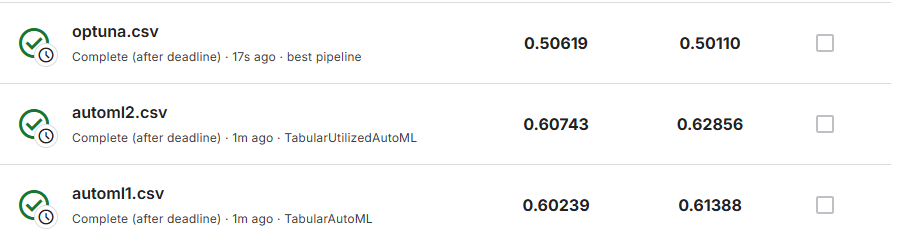